In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
from sklearn.preprocessing import *
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split

torch.manual_seed(411)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Snapshot of model capturing 3-body interaction

Goal is to show NN-based method generalizes well to situations where we don't necessarily have good physics-constraints (like we do for 2-body case). Plus, our NN model achieves accuracy that even outperforms Stokesian Dynamics, HiGNN's ground truth.

+ 69k sphere samples, all with torque, but magnitude of torque differs between samples.
+ We can now capture the nearfield pattern (U3) in Helen's test, previously it was completely being missed.

Here is U3 error line for previous code (L2 loss, with torque bug). New figure is in a cell below.

![prev_U3_pattern](prev_U3_pattern.png)

In [2]:
root = "../data/3b_cross"
times = os.listdir(root)
xs, ys = [], []
for f in times:
    file = f[1:]
    x = np.load(f"{root}/X{file}")
    y = np.load(f"{root}/Y{file}")
    xs.append(x)
    ys.append(y)

X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)

XY = np.hstack([X, Y])          # shape: (total_rows, 16)
print(XY.shape)

column_names = [
    # X columns 
    "x_s", "y_s", "z_s", "dist_s", "min_dist_s",
    "f_x_s", "f_y_s", "f_z_s",
    "tor_x_s", "tor_y_s", "tor_z_s",
    
    "x_k", "y_k", "z_k", "dist_k", "min_dist_k",
    # Y columns
    "vel_x", "vel_y", "vel_z",
    "angvel_x", "angvel_y", "angvel_z"
]

df = pd.DataFrame(XY, columns=column_names)
df.shape, df.columns

(40000, 22)


((40000, 22),
 Index(['x_s', 'y_s', 'z_s', 'dist_s', 'min_dist_s', 'f_x_s', 'f_y_s', 'f_z_s',
        'tor_x_s', 'tor_y_s', 'tor_z_s', 'x_k', 'y_k', 'z_k', 'dist_k',
        'min_dist_k', 'vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y',
        'angvel_z'],
       dtype='object'))

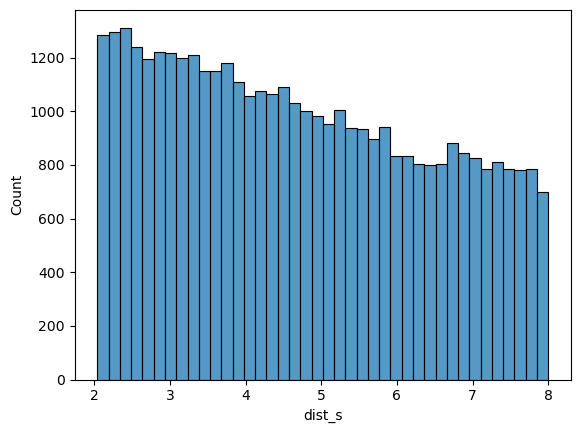

In [3]:
sns.histplot(df["dist_s"], bins=40);

In [4]:
df['dist_sk'] = np.sqrt(
    (df['x_s'] - df['x_k'])**2 +
    (df['y_s'] - df['y_k'])**2 +
    (df['z_s'] - df['z_k'])**2
)

# center all distance columns
mean_dist_s = df['dist_s'].mean()
mean_dist_k = df['dist_k'].mean()
mean_dist_sk = df['dist_sk'].mean()
print("Distance means:", mean_dist_s, mean_dist_k, mean_dist_sk)

df['dist_s'] -= mean_dist_s
df['dist_k'] -= mean_dist_k
df['dist_sk'] -= mean_dist_sk

df['dist_s_sq'] = df['dist_s']**2
df['dist_k_sq'] = df['dist_k']**2
df['dist_sk_sq'] = df['dist_sk']**2

df['dist_s_sqsq'] = df['dist_s_sq']**2
df['dist_k_sqsq'] = df['dist_k_sq']**2
df['dist_sk_sqsq'] = df['dist_sk_sq']**2

# Convert all actual position columns to relative positions
origin = np.array([0.0, 0.0, 0.0]) #target is at origin

# dvec = target-source
df['x_s'] = origin[0] - df['x_s']
df['y_s'] = origin[1] - df['y_s']
df['z_s'] = origin[2] - df['z_s']
df['x_k'] = origin[0] - df['x_k']
df['y_k'] = origin[1] - df['y_k']
df['z_k'] = origin[2] - df['z_k']

df.shape, df.columns

Distance means: 4.724224262198524 4.701194833185605 6.676046130020521


((40000, 29),
 Index(['x_s', 'y_s', 'z_s', 'dist_s', 'min_dist_s', 'f_x_s', 'f_y_s', 'f_z_s',
        'tor_x_s', 'tor_y_s', 'tor_z_s', 'x_k', 'y_k', 'z_k', 'dist_k',
        'min_dist_k', 'vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y',
        'angvel_z', 'dist_sk', 'dist_s_sq', 'dist_k_sq', 'dist_sk_sq',
        'dist_s_sqsq', 'dist_k_sqsq', 'dist_sk_sqsq'],
       dtype='object'))

In [5]:
def prepare_vectors(df):
    force_cols = [
        'f_x_s', 'f_y_s', 'f_z_s', 'tor_x_s', 'tor_y_s', 'tor_z_s'    ]
    output_cols = [
        'vel_x', 'vel_y', 'vel_z',
        'angvel_x', 'angvel_y', 'angvel_z'
    ]
    dvec_s = ['x_s', 'y_s', 'z_s']
    feat_2b_s = ['dist_s', 'dist_s_sq', 'dist_s_sqsq', 'min_dist_s']
    dvec_k = ['x_k', 'y_k', 'z_k']
    feat_2b_k = ['dist_k', 'dist_k_sq', 'dist_k_sqsq', 'min_dist_k']
    sk_feats = ['dist_sk', 'dist_sk_sq', 'dist_sk_sqsq']

    feature_cols = dvec_s + dvec_k + feat_2b_s + feat_2b_k + sk_feats
    print("Using features:", feature_cols)
    
    dist_vec   = df[feature_cols].values
    force_vec  = df[force_cols].values
    output_vec = df[output_cols].values
    return dist_vec, force_vec, output_vec

In [6]:
feat, force, vel = prepare_vectors(df)
feat, force, vel = convert_to_tensors(feat, force, vel)


tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))
indices = tmp.pop()

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape

Using features: ['x_s', 'y_s', 'z_s', 'x_k', 'y_k', 'z_k', 'dist_s', 'dist_s_sq', 'dist_s_sqsq', 'min_dist_s', 'dist_k', 'dist_k_sq', 'dist_k_sqsq', 'min_dist_k', 'dist_sk', 'dist_sk_sq', 'dist_sk_sqsq']


(torch.Size([32000, 17]), torch.Size([32000, 6]), torch.Size([8000, 17]))

In [7]:
train_dist_tensor[:,-1].max()

tensor(6324.0659, device='cuda:0')

In [8]:
# viscosity = 1.0
# eigens = None

# class ScNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super(ScNetwork, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 5),
#             nn.Tanh()
#         )
        
#     def forward(self, r, print_scalars=False):
#         return self.layers(r)

#     def predict_mobility(self, X, print_scalars=False):
#         d_vec, r = X[:,:3], X[:,3]
#         sc = self.forward(X, print_scalars)
        
#         d_vec = d_vec/ r.unsqueeze(-1)
#         TT = sc[:, 0].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
#                 sc[:, 1].unsqueeze(1).unsqueeze(2) * L2(d_vec) # TODO: d_vec or r?
#         RT = sc[:, 2].unsqueeze(1).unsqueeze(2) * L3(d_vec)
#         RR = sc[:, 3].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
#                 sc[:, 4].unsqueeze(1).unsqueeze(2) * L2(d_vec)
    
#         K = torch.zeros((len(X), 6, 6), dtype=torch.float32, device=X.device)
    
#         K[:, :3, :3] = TT  # Top-left block
#         K[:, 3:, :3] = RT  # Bottom-left block
#         K[:, :3, 3:] = RT  # Top-right block (transpose of B)
#         K[:, 3:, 3:] = RR  # Bottom-right block

#         # nonSPD = 0
#         # global eigens
#         # if not self.training:
#         #     print("Activating SPSD check..")
#         #     for i in range(len(K)):
#         #         eigs = np.linalg.eigvals(K[i].detach().cpu())
#         #         #assert np.all(eigs>=0), f"NOT SPSD: {eigs}"
#         #         if not np.all(eigs>=-.0001):
#         #             eigens = eigs.copy()
#         #             nonSPD += 1
#         #     print(f"{nonSPD=}, {len(K)}")
#         return K

#     def predict_velocity(self, X, force, return_M=False):
#         M = self.predict_mobility(X)/viscosity
#         velocity = torch.bmm(M, force.unsqueeze(-1)).squeeze(-1)
#         if return_M:
#             return velocity, M
#         return velocity


In [9]:
viscosity = 1.0
eigens = None

class ThreeBodyNet(nn.Module):
    def __init__(self, input_dim, two_nn_path, median_2b, mean_dist_s):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 36)
        )
        self.two_nn = torch.jit.load(two_nn_path, map_location=device).eval()
        self.median_2b = median_2b
        self.mean_dist_s = mean_dist_s
        
    def forward(self, X):
        return self.net(X)           # shape [B,10]

    @torch.jit.export
    def predict_velocity(self, X, force_s):
        coeff = self.forward(X)                     # [B,10]

        M_3b = torch.reshape(coeff, (-1, 6, 6))
        v = torch.bmm(M_3b, force_s.unsqueeze(-1)).squeeze(-1)
        return v

    def predict_velocity_total(self, X3b, force_s, mu=1.0):
        return self.predict_two_body_from_triplet(X3b, force_s, mu) + \
               self.predict_velocity(X3b, force_s)
        

    def predict_two_body_from_triplet(self, X3b, force_s, mu=1.0):
        """
        X3b: [B, 17] triplet features in notebook order
        force_s: [B, 6] source force/torque in the lab frame (only s is nonzero)
        Returns: [B, 6] predicted two-body velocity on t due to s only
        """
        # Extract dvec_s = (x_s, y_s, z_s) which is target - source (already in lab frame)
        dvec_s = X3b[:, 0:3]                         # [B,3]

        # Recover raw dist_s: centered + mean
        dist_s_centered = X3b[:, 6]                  # [B]
        dist_s_raw = dist_s_centered + self.mean_dist_s

        # Build 2-body inputs
        min_dist_raw = dist_s_raw - 2.0              # [B]
        r2 = (dist_s_raw - self.median_2b)**2
        r4 = r2 * r2

        X2b = torch.cat(
            [dvec_s,
             dist_s_raw.unsqueeze(1),
             r2.unsqueeze(1),
             r4.unsqueeze(1),
             min_dist_raw.unsqueeze(1)],
            dim=1
        ).to(device)                                    # [B, 7] (sphere case)

        # Forces: only source on (s) is nonzero; target (t) = zeros
        Fs_target = torch.zeros_like(force_s, device=device)  # [B,6]
        Ft_source = force_s.to(device)                        # [B,6]

        mu_tensor = torch.tensor(float(mu), dtype=torch.float32, device=device)
        v2b = self.two_nn.predict_velocity(X2b, Fs_target, Ft_source, mu_tensor)  # [B,6]
        return v2b

    def make_residual_labels(self, X3b, force_s, y_total_3b, mu=1.0):
        """
        y_total_3b: [B,6] ground truth velocity on t from 3-body solve (s active, k passive)
        Returns residual labels: y_res = y_total_3b - v2b_pred
        """
        v2b = self.predict_two_body_from_triplet(X3b, force_s, mu)
        return y_total_3b.to(device) - v2b

## Modelling

In [10]:
input_dim = train_dist_tensor.shape[1]
batch_size = 256
epochs = 375 #350 seemed important for mob_op_3b acc on reference.csv

twob_path = "../data/models/two_body_combined_model.pt"
median_2b = 5.008307682776568 #copied from 2b training notebook
model = ThreeBodyNet(input_dim, twob_path,median_2b, mean_dist_s).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


criterion = nn.MSELoss()
#criterion = nn.L1Loss()
n_batches = train_velocity_tensor.shape[0]//batch_size
n_batches, n_batches*batch_size, len(train_dist_tensor)

(125, 32000, 32000)

In [11]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)

with torch.no_grad():
    y_residual = model.make_residual_labels(
        train_dist_tensor, 
        train_force_tensor, 
        train_velocity_tensor, mu=1.0)

In [12]:
    
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, y_residual = shuffle_tensors(
        train_dist_tensor, train_force_tensor, y_residual
    )
    for it in range(n_batches):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force_s = train_force_tensor[indices]         
        Y = y_residual[indices]  

        Y_b = model.predict_velocity(X, force_s)
        loss = criterion(Y_b, Y)
        
        loss.backward()
        avg += loss.item()
        avg_data += 0 #data_loss.item()
        #avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_batches}')
        losses.append(avg/n_batches)
        data_losses.append(avg_data/n_batches)
        spsd_losses.append(avg_spsd/n_batches)

torch.save(model.state_dict(), "3body_cross.wt")

Epoch 0, Loss: 0.20088727960735558
Epoch 5, Loss: 0.005399776466190815
Epoch 10, Loss: 0.00444142691232264
Epoch 15, Loss: 0.0037027840949594975
Epoch 20, Loss: 0.002687318639829755
Epoch 25, Loss: 0.0016465883422642946
Epoch 30, Loss: 0.0009324872815050185
Epoch 35, Loss: 0.0005761977785732598
Epoch 40, Loss: 0.00041270846710540353
Epoch 45, Loss: 0.00037360200309194625
Epoch 50, Loss: 0.0003205043689813465
Epoch 55, Loss: 0.00028082768525928257
Epoch 60, Loss: 0.0002561712210299447
Epoch 65, Loss: 0.00018485476926434786
Epoch 70, Loss: 0.0001580280650523491
Epoch 75, Loss: 0.0001357222703518346
Epoch 80, Loss: 0.0001258923436398618
Epoch 85, Loss: 0.00013915866904426366
Epoch 90, Loss: 0.00013436581660062073
Epoch 95, Loss: 8.634698652895167e-05
Epoch 100, Loss: 0.002148534922860563
Epoch 105, Loss: 0.0007858596108853817
Epoch 110, Loss: 0.00033251489175017924
Epoch 115, Loss: 0.00020721115823835136
Epoch 120, Loss: 0.00016318538354244083
Epoch 125, Loss: 0.00014074658474419265
Epoch

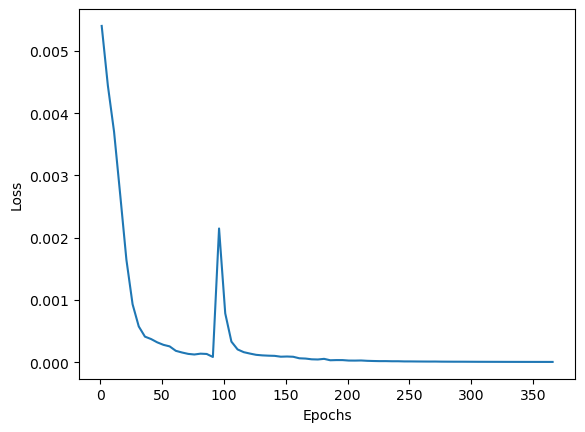

In [13]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.savefig("loss.png");

## Evaluation

In [14]:
model = ThreeBodyNet(input_dim, twob_path,median_2b, mean_dist_s).to(device)
model.load_state_dict(torch.load("3body_cross.wt", weights_only=True))
model.eval()

with torch.no_grad():
    val_output = model.predict_velocity_total(val_dist_tensor, val_force_tensor)

In [15]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 185
val_output[jj], val_velocity_tensor[jj], val_dist_tensor[jj, [6,10,14]]

(tensor([-0.110206,  0.235916, -0.276246,  0.007785,  0.037312,  0.030855],
        device='cuda:0'),
 tensor([-0.109013,  0.234673, -0.274385,  0.002120,  0.036132,  0.035760],
        device='cuda:0'),
 tensor([-1.258089, -2.584173, -1.851157], device='cuda:0'))

In [16]:
criterion = nn.MSELoss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean()**.5)

Root Mean Squared error for each of 6 output variables:
 tensor([0.003094, 0.003382, 0.003277, 0.001911, 0.001937, 0.001901],
       device='cuda:0')
Actual Magnitude:
  tensor([0.128210, 0.127427, 0.125916, 0.021024, 0.021028, 0.021496],
       device='cuda:0')
RMSE: tensor(0.002670, device='cuda:0')


In [17]:
#### Mean Relative Absolute Error
valid_mask = torch.abs(val_velocity_tensor) > 1e-6

filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)

a,_ = torch.nanmedian(relative_error, dim=0)
a*100

tensor([0.998164, 1.025726, 1.022120, 5.481101, 5.326463, 5.453431],
       device='cuda:0')

In [18]:
a = torch.nanmean(relative_error, dim=0)
a*100

tensor([ 6.394398,  8.970096,  6.233822, 37.046196, 30.612293, 55.578732],
       device='cuda:0')

In [19]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

tensor([2.413118, 2.654017, 2.602592, 9.087449, 9.210760, 8.845416],
       device='cuda:0')

In [20]:
scripted_model = torch.jit.script(model)
scripted_model.save("../data/models/3body_cross.pt")

# Finetuning didn't work
# ft_2b_path = "../data/models/two_body_combined_model_finetuned.pt"
# model.two_nn.eval()  # optional, but recommended
# model.two_nn.save(ft_2b_path)


## 3-Sphere test from Wilson, Sect 4.2
*In this section we consider a problem which has only one (reﬂective) symmetry, and in which true lubrication forces oc-
cur, through the approach of close spheres. The spheres (each of radius a) are arranged in an equilateral triangle of side s as
before. A force of magnitude 6pla is applied to sphere 1, acting towards the centroid of the triangle, and spheres 2 and 3 are
force-free and torque-free.*

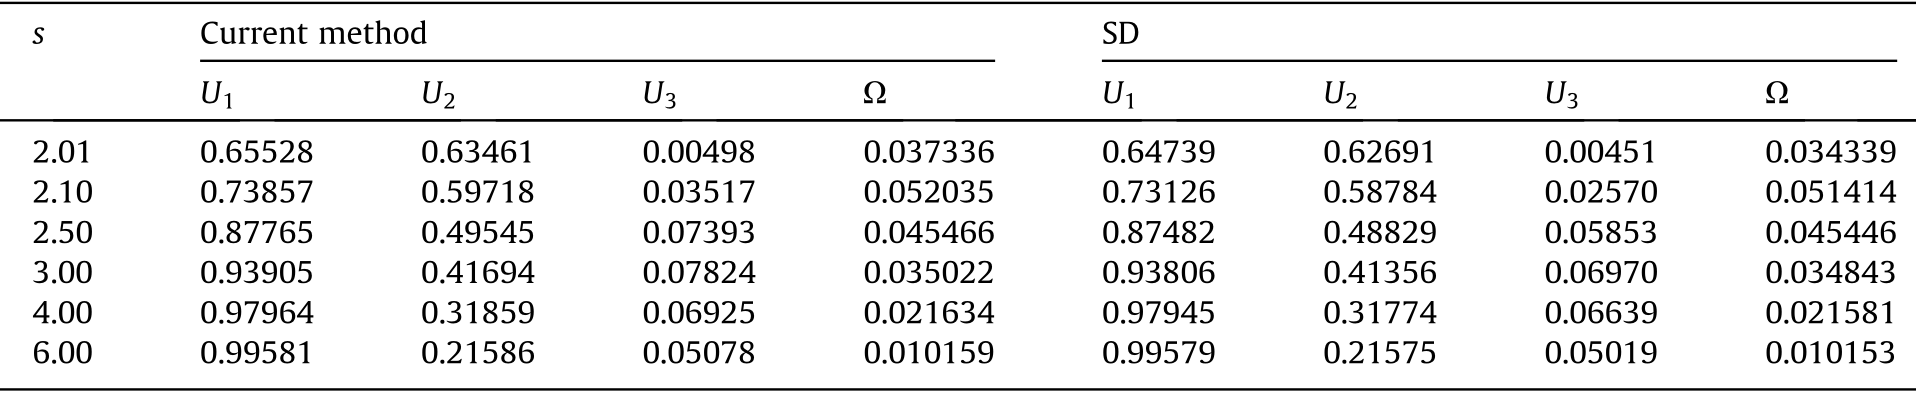

In [21]:
# Creating the DataFrame programmatically

# Define hierarchical column indexing
columns = pd.MultiIndex.from_tuples([
    ("Helen's method", 'U1'), ("Helen's method", 'U2'), ("Helen's method", 'U3'), ("Helen's method", 'Ω'),
    ('SD', 'U1'), ('SD', 'U2'), ('SD', 'U3'), ('SD', 'Ω'),
])

s_values = [2.10, 2.50, 3.00, 4.00, 6.00]

# Define the data
data = [
    #[0.65528, 0.63461, 0.00498, 0.037336, 0.64739, 0.62691, 0.00451, 0.034339],
    [0.73857, 0.59718, 0.03517, 0.052035, 0.73126, 0.58784, 0.02570, 0.051414],
    [0.87765, 0.49545, 0.07393, 0.045466, 0.87482, 0.48829, 0.05853, 0.045446],
    [0.93905, 0.41694, 0.07824, 0.035022, 0.93806, 0.41356, 0.06970, 0.034843],
    [0.97964, 0.31859, 0.06925, 0.021634, 0.97945, 0.31774, 0.06639, 0.021581],
    [0.99581, 0.21586, 0.05078, 0.010159, 0.99579, 0.21575, 0.05019, 0.010153]
]

# Construct the DataFrame
df_filled = pd.DataFrame(data, index=s_values, columns=columns).drop(columns=[("Helen's method", 'U1'), ('SD', 'U1')])

relative_error = (df_filled['SD'] - df_filled["Helen's method"]).abs() / df_filled["Helen's method"] * 100

relative_error.columns = pd.MultiIndex.from_tuples(
    [('SD Error', f' % {col}') for col in relative_error.columns]
)
# Concatenate the new data with the existing DataFrame
df_updated = pd.concat([df_filled, relative_error], axis=1)

In [22]:
def generate_test_features_extended(dist_vals, R, training_means):
    """
    Generates the extended feature set for the 3-sphere equilateral triangle test case.

    Args:
        dist_vals (list or np.array): Array of surface-to-surface gap distances (S).
        R (float): Radius of the spheres.
        training_means (pd.Series): A pandas Series containing the mean values for 
                                    'dist2', 'dist3', and 'dist23' from the original
                                    training dataset. This is essential for consistent
                                    feature centering.
    
    Returns:
        pd.DataFrame: A DataFrame containing the full, extended feature set in the
                      correct order for the model.
    """
    # --- Step 1: Generate the 11 base features ---
    base_column_names = ['c2_x', 'c2_y', 'c2_z', 'dist2', 'min_dist2', 'dist23',
                         'c3_x', 'c3_y', 'c3_z', 'dist3', 'min_dist3']

    features_list = []
    for S in dist_vals:
        D = 2 * R + S  # Center-to-center distance
        features_list.append([
            D/2.0, 0, (np.sqrt(3)/2.0)*D, 
            D, S, D,
            D,0,0, 
            D, S])
        
    # Create the initial DataFrame
    features_df = pd.DataFrame(data=features_list, columns=base_column_names)

    # --- Step 2: Engineer the new features ---
    epsilon = 1e-6
    
    # Inverse and Log features
    # features_df['inv_min_dist2'] = 1.0 / (features_df['min_dist2'] + epsilon)
    # features_df['inv_min_dist3'] = 1.0 / (features_df['min_dist3'] + epsilon)
    # features_df['log_min_dist2'] = np.log(features_df['min_dist2'] + epsilon)
    # features_df['log_min_dist3'] = np.log(features_df['min_dist3'] + epsilon)

    # Centered Higher-Order Polynomial features
    poly_cols = ['dist2', 'dist3', 'dist23']
    for col in poly_cols:
        mean_val = training_means[col] # Use the mean from the TRAINING data
        centered_col = features_df[col] - mean_val
        features_df[f'{col}_sq_centered'] = centered_col**2
        features_df[f'{col}_quad_centered'] = centered_col**4
        
    # --- Step 3: Ensure the final column order matches the training data ---
    # This order must be identical to the one generated by `prepare_vectors_extended`
    final_column_order = [
        'c2_x', 'c2_y', 'c2_z', 'dist2', 'min_dist2', 'dist23', 'c3_x', 'c3_y', 'c3_z', 'dist3', 'min_dist3',
        #'inv_min_dist2', 'inv_min_dist3', 
        #'log_min_dist2', 'log_min_dist3',
        'dist2_sq_centered', 'dist2_quad_centered', 'dist3_sq_centered', 
        'dist3_quad_centered', 'dist23_sq_centered', 'dist23_quad_centered'
    ]
    
    # Reorder the DataFrame columns
    features_df = features_df[final_column_order]
    print(features_df.shape)
    return features_df

In [23]:
R = 1.0  
S_vals = [.1, .5, 1.0, 2.0, 4.0]
dist_vals = np.concatenate((np.linspace(.09, 6.1, num=160), np.array(S_vals)), axis=0)

test_features_df = generate_test_features_extended(dist_vals, R, training_means)

# Convert to a tensor for the model
features = torch.tensor(test_features_df.values, dtype=torch.float32)
force = [[0, 0, -1.0 * 6* np.pi, 0, 0, 0]]*len(dist_vals)
force = torch.tensor(force.copy(), dtype=torch.float32)

model = TripletCoeffNet(input_dim).to(device)
model.load_state_dict(torch.load("triplet_coeff_net.pth", weights_only=True))
model.eval()

with torch.no_grad():
    velocity = model.predict_velocity(features, force).clone().cpu().numpy()

#velocity = scaler_y.inverse_transform(velocity)
#velocity[:,3:] /= 2
#velocity /= 5

NameError: name 'training_means' is not defined

In [ ]:
nn_df = pd.DataFrame(index=dist_vals+2.0, columns=pd.MultiIndex.from_tuples(
    [('NN', col) for col in df_updated['SD'].columns]
))
for i, S in enumerate(dist_vals):
    v = np.abs(velocity[i])
    nn_df.loc[S+2.0] = [v[2], v[0], v[4]]

nn_df_tmp = nn_df.loc[np.array(S_vals)+2.0]
df_result = pd.concat([df_updated, nn_df_tmp], axis=1)
df_result[["Helen's method", "SD", "NN"]]

In [ ]:
rel_error = (df_result['NN'] - df_result["Helen's method"]).abs() / df_result["Helen's method"] * 100

rel_error.columns = pd.MultiIndex.from_tuples(
    [('NN Error', f' % {col}') for col in rel_error.columns]
)
# Concatenate the new data with the existing DataFrame
df_result_err = pd.concat([df_result, rel_error], axis=1)

In [ ]:
df_result_err[['SD Error', 'NN Error']]

In [ ]:
(df_result_err['NN Error']<df_result_err['SD Error']).sum()

In [ ]:
rpy_data = {
    2.1: {"% U2": 6.64244, "% U3": 140.29719, "% Ω": 263.41696},
    2.5: {"% U2": 2.10919, "% U3": 19.48409,  "% Ω": 231.96674},
    3.0: {"% U2": 0.62075, "% U3": 7.61364,   "% Ω": 218.97284},
    4.0: {"% U2": 0.07239, "% U3": 2.58649,   "% Ω": 208.33641},
    6.0: {"% U2": 0.00163, "% U3": 0.66868,   "% Ω": 202.53634}
}
df_rpy = pd.DataFrame.from_dict(rpy_data, orient='index')
df_rpy

In [ ]:
sns.lineplot(nn_df, x=nn_df.index, y=('NN', 'U2'), label="NN");
sns.scatterplot(df_result, x=df_result.index, y=('SD', 'U2'), label="SD")
sns.scatterplot(df_result, x=df_result.index, y=("Helen's method", 'U2'), label="Helen");
plt.legend();

In [ ]:
sns.lineplot(nn_df, x=nn_df.index, y=('NN', 'U3'), label="NN");
sns.scatterplot(df_result, x=df_result.index, y=('SD', 'U3'), label="SD")
sns.scatterplot(df_result, x=df_result.index, y=("Helen's method", 'U3'), label="Helen");
plt.xlabel("Triangle side (s)")
plt.ylabel("U3")
plt.legend();
plt.savefig("U3_vs_SD.pdf");

In [ ]:
sns.lineplot(nn_df, x=nn_df.index, y=('NN', 'Ω'), label="NN", color='blue');
sns.scatterplot(df_result, x=df_result.index, y=('SD', 'Ω'), label="SD", color='red')
sns.scatterplot(df_result, x=df_result.index, y=("Helen's method", 'Ω'), label="Helen", color='green');
plt.legend();

s: 2.5

  U1: -1 | expected: -0.87765) | relative error: 0.139406

  U2: -0.485 | expected: -0.49545) | relative error: 0.0210919

  U3: 0.0883346 | expected: 0.07393) | relative error: 0.194841

s: 3

  U1: -1 | expected: -0.93905) | relative error: 0.064906

  U2: -0.414352 | expected: -0.41694) | relative error: 0.00620748

  U3: 0.0841969 | expected: 0.07824) | relative error: 0.0761364

s: 4

  U1: -1 | expected: -0.97964) | relative error: 0.0207831

  U2: -0.318359 | expected: -0.31859) | relative error: 0.000723893

  U3: 0.0710411 | expected: 0.06925) | relative error: 0.0258649

s: 6

  U1: -1 | expected: -0.99581) | relative error: 0.00420763

  U2: -0.215856 | expected: -0.21586) | relative error: 1.63e-05

  U3: 0.0511196 | expected: 0.05078) | relative error: 0.00668679
 

In [ ]:
np.set_printoptions(precision=5, suppress=True)

In [ ]:
a = df['min_dist2']<.11 
b = df['min_dist3']<.11
(a & b).sum(), len(df)